### Benchmark SeismicPro methods

| Function Name| Optimal target |
| :---:        | :----: |
|*__GATHER__*||
| [copy](#copy) | threads |
| [get_item](#get_item) | for |
| [dump](#dump) | for |
| [sort](#sort) | threads |
| [pick_to_mask](#pick_to_mask) | threads |
| [mask_to_pick](#mask_to_pick) | threads |
| [mute](#mute) | threads |
| [calculate_vertical_velocity_spectrum](#calculate_vertical_velocity_spectrum) | for |
| [calculate_residual_velocity_spectrum](#calculate_residual_velocity_spectrum) | for |
| [get_central_gather](#get_central_gather) | threads |
| [apply_nmo](#apply_nmo) | threads |
| [stack](#stack) | threads |
| [scale_standard](#scale_standard) | threads |
| [scale_maxabs](#scale_maxabs) | for |
| [scale_minmax](#scale_minmax) | for |
| [crop](#crop) | threads |
| [resample](#resample) | threads |
| [bandpass_filter](#bandpass_filter) | threads |
| [apply_agc](#apply_agc) | threads |
| [undo_agc](#undo_agc) | threads |
| [apply_sdc](#apply_sdc) | threads |
| [undo_sdc](#undo_sdc) | threads |
| [calculate_refractor_velocity](#calculate_refractor_velocity) | for |
| [apply_lmo](#apply_lmo) | threads |
|*__VELOCITY SPECTRUM__*||
| [calculate_stacking_velocity](#calculate_stacking_velocity) | for |
|*__CROPPED GATHER__*||
| [assemble_gather](#assemble_gather) | for |

All results are obtained for the following configuration:
* CPU - Intel(R) Xeon(R) Gold 6242R CPU @ 3.10GHz x 20
* 512 Gb RAM

In [1]:
import os
import sys
import tempfile

import numpy as np
from batchflow import Pipeline

from benchmark import Benchmark
from utils import make_benchmark_data

sys.path.insert(0, '..')
from seismicpro import SeismicDataset, Muter, RefractorVelocity
from seismicpro.const import DEFAULT_STACKING_VELOCITY

Define constants

In [2]:
BATCH_SIZES = list(range(1, 11)) + list(range(20, 51, 10))
N_ITERS = 10
TARGETS = ('for', 'threads')
SHUFFLE = 42

Create temporary folder to store benchmark data and generate paths

In [3]:
tmp_dir = tempfile.TemporaryDirectory()
DATA_PATH = os.path.join(tmp_dir.name, 'benchmark_data.sgy')
DUMP_PATH = os.path.join(tmp_dir.name, 'dump')

Create survey and the dataset

In [4]:
survey, supergather_survey = make_benchmark_data(DATA_PATH)

dataset = SeismicDataset(survey)
supergather_dataset = SeismicDataset(supergather_survey)

load_pipeline = Pipeline().load(src='raw', fmt='sgy')
sort_pipeline = load_pipeline + Pipeline().sort(src='raw', by='offset')

Common shot gathers generated:   0%|          | 0/6400 [00:00<?, ?it/s]

Trace headers loaded:   0%|          | 0/2464900 [00:00<?, ?it/s]

In [5]:
default_kwargs = {"targets": TARGETS, "batch_sizes": BATCH_SIZES, "dataset": dataset}
supergather_kwargs = {"targets": TARGETS, "batch_sizes": BATCH_SIZES, "dataset": supergather_dataset}
long_running_kwargs = {"targets": TARGETS, "batch_sizes": BATCH_SIZES[:-3], "dataset": dataset}

### copy

100%|██████████| 28/28 [00:24<00:00,  1.16it/s]


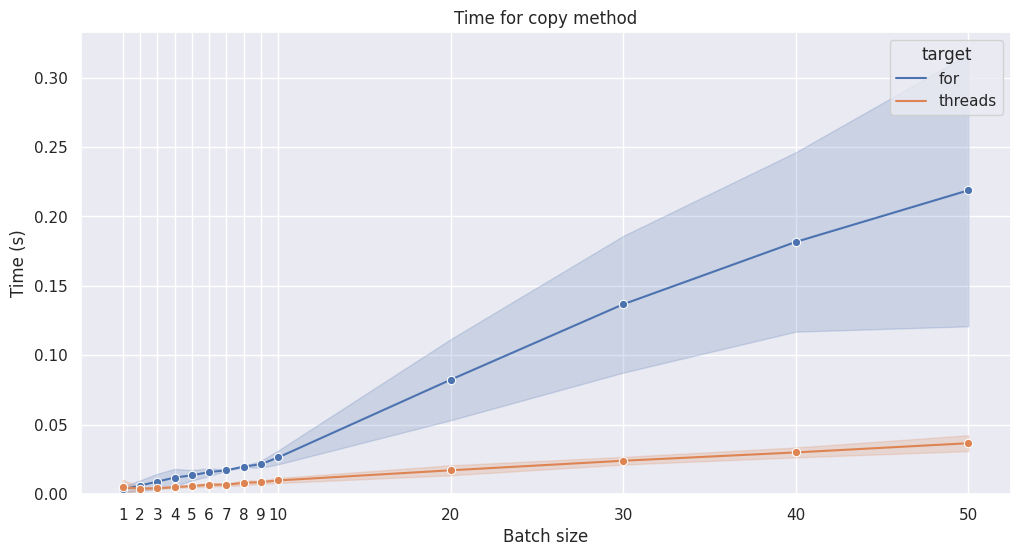

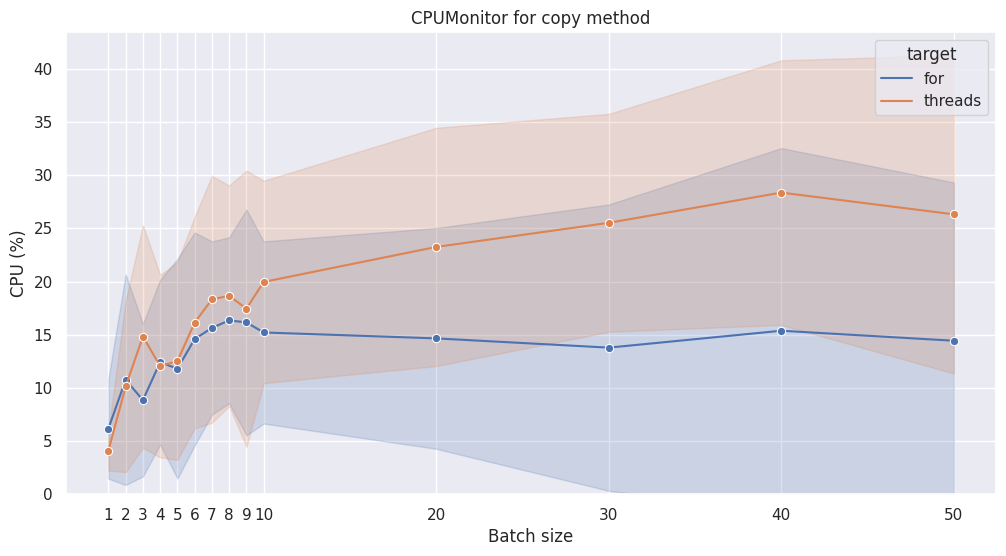

In [6]:
copy_bm = Benchmark(method_name='copy', method_kwargs={'src': 'raw', 'dst': 'raw_copy'},
                    root_pipeline=load_pipeline, **default_kwargs)

copy_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### get_item

100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


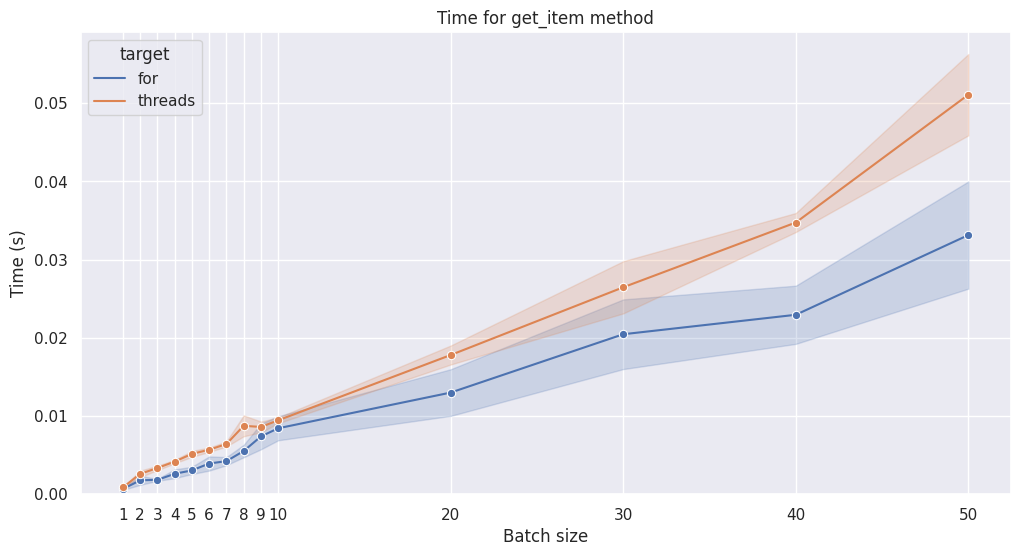

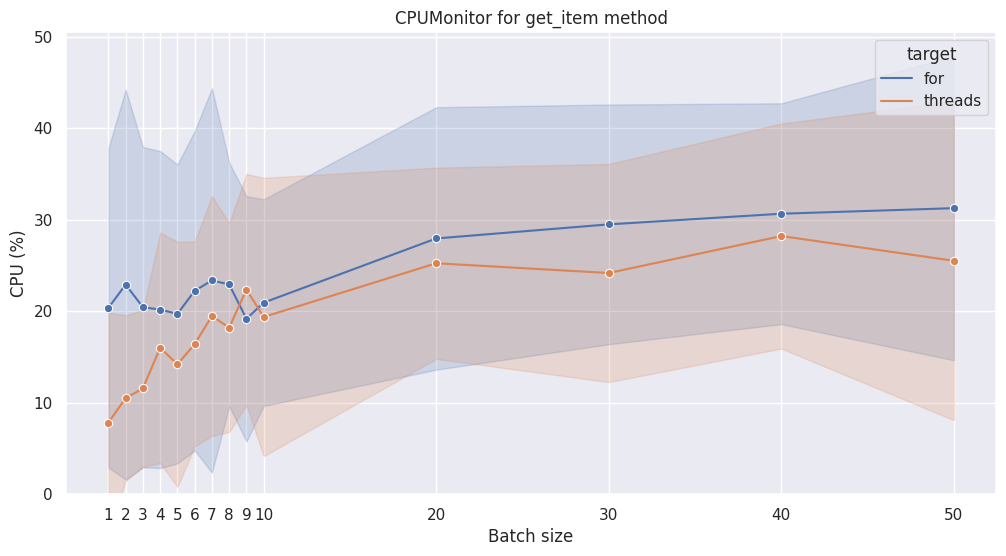

In [7]:
get_item_bm = Benchmark(method_name='get_item', method_args=([1, 2, 5],), method_kwargs={'src': 'raw'},
                        root_pipeline=load_pipeline, **default_kwargs)

get_item_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### dump

100%|██████████| 22/22 [14:16<00:00, 38.93s/it]


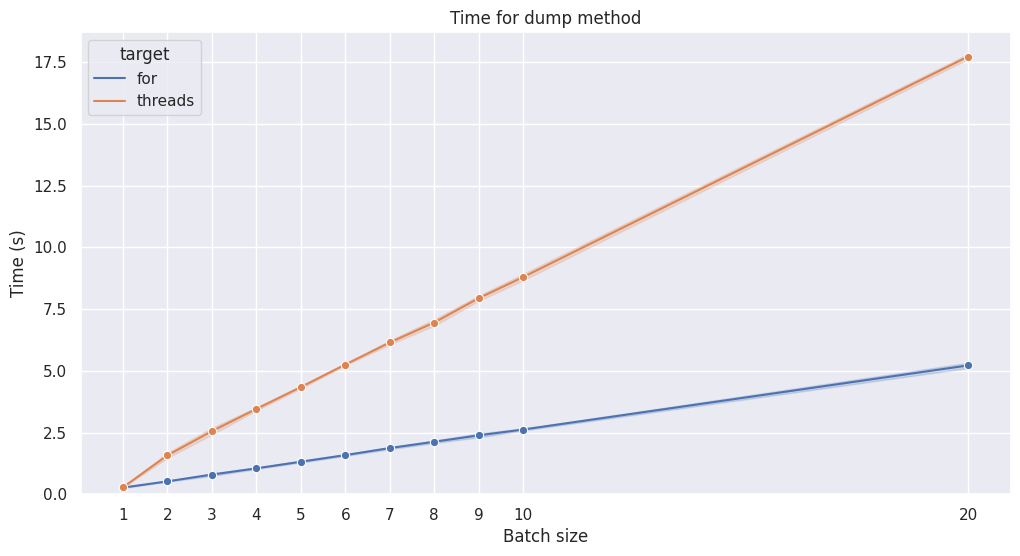

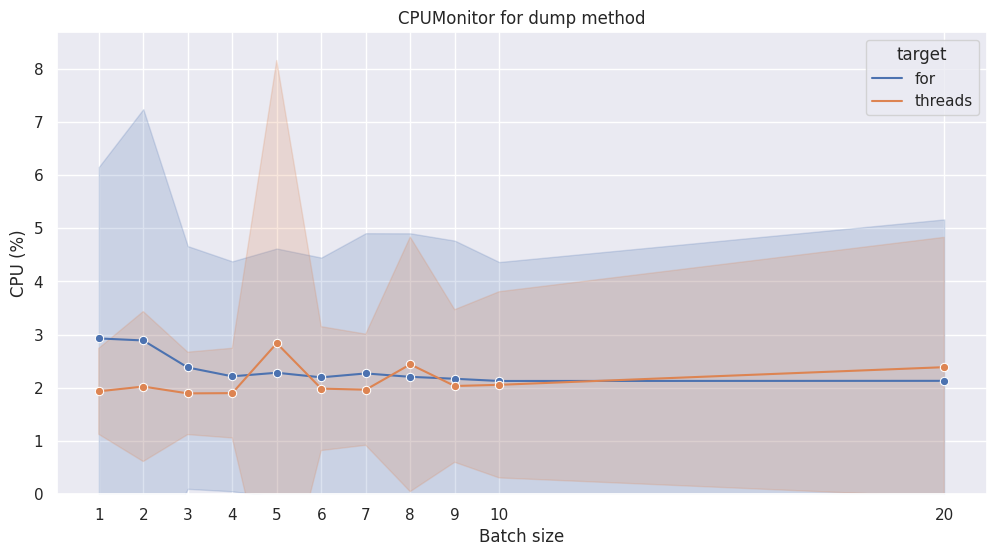

In [8]:
dump_bm = Benchmark(method_name='dump', method_kwargs={'src': 'raw', 'path': DUMP_PATH},
                    root_pipeline=load_pipeline, **long_running_kwargs)

dump_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### sort

100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


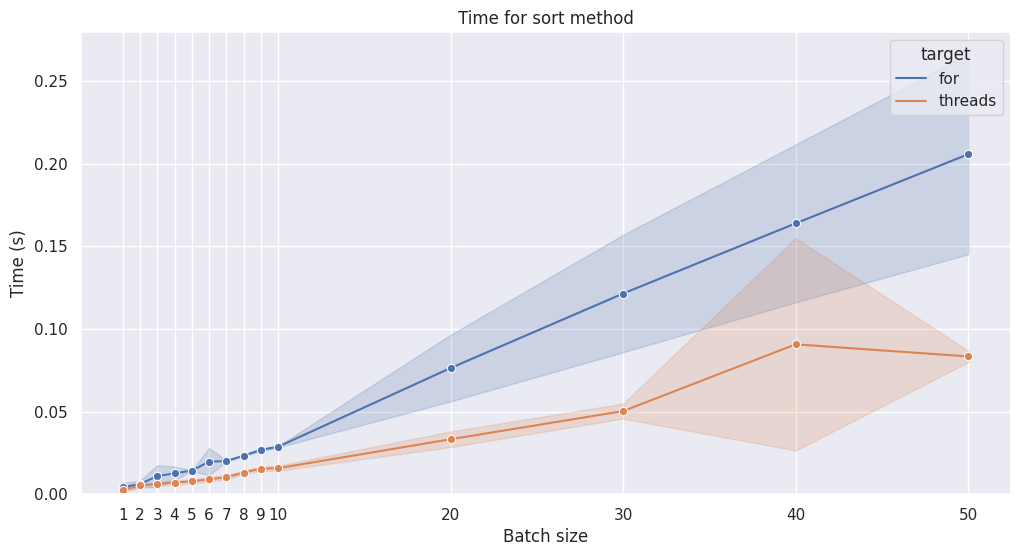

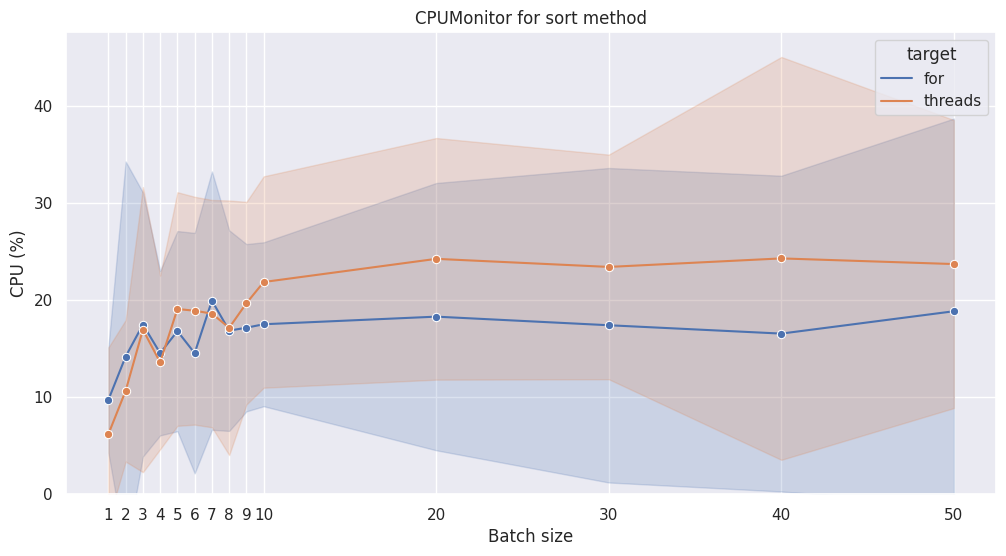

In [9]:
sort_bm = Benchmark(method_name='sort', method_kwargs={'src': 'raw', 'by': 'offset'},
                    root_pipeline=load_pipeline, **default_kwargs)

sort_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### pick_to_mask

100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


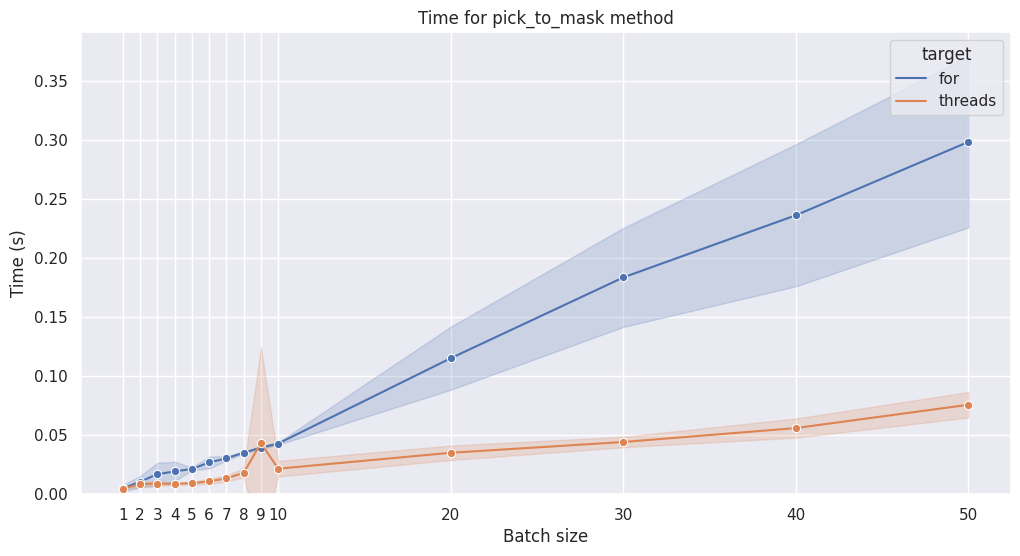

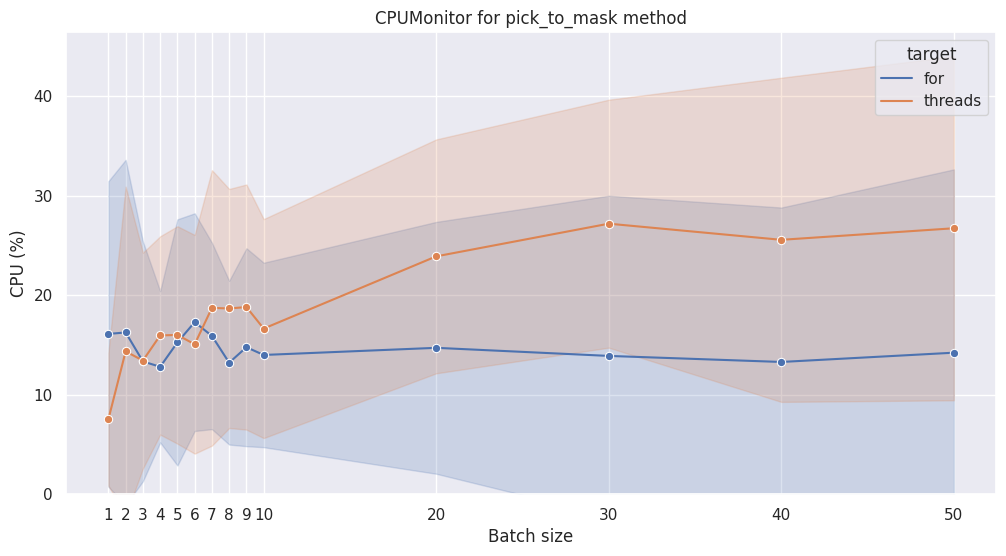

In [10]:
pick_to_mask_bm = Benchmark(method_name='pick_to_mask', method_kwargs={'src': 'raw'},
                            root_pipeline=load_pipeline, **default_kwargs)

pick_to_mask_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mask_to_pick

100%|██████████| 28/28 [00:25<00:00,  1.08it/s]


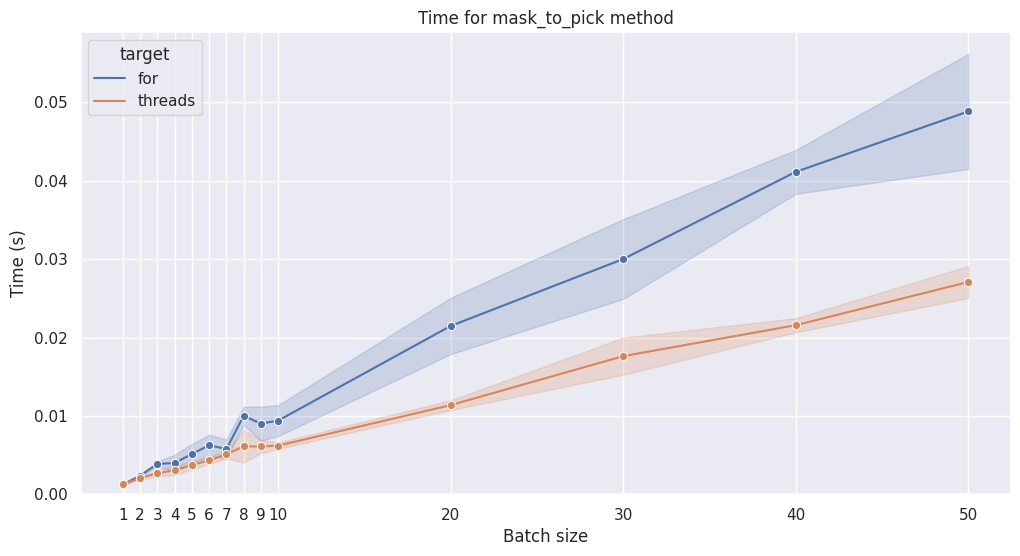

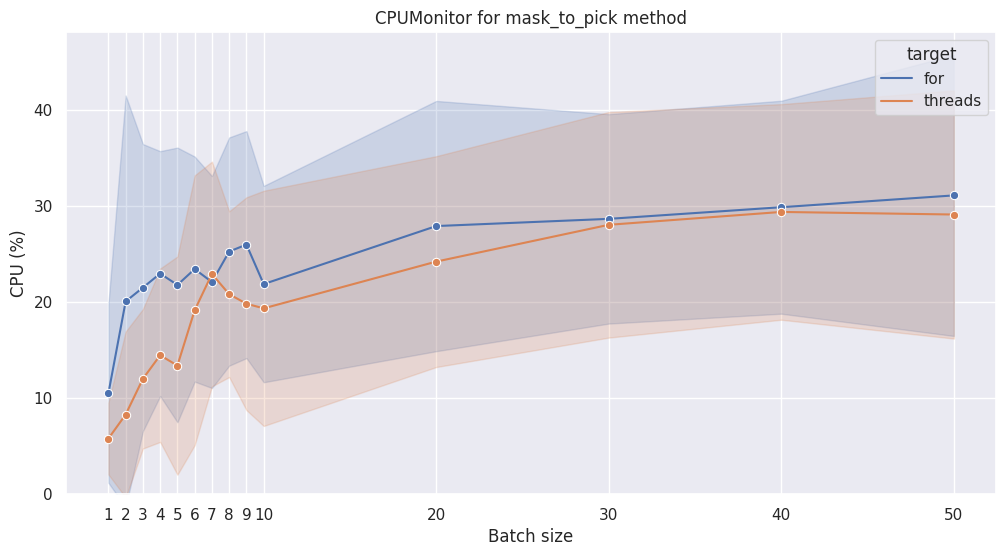

In [11]:
mask_to_pick_ppl = load_pipeline + Pipeline().pick_to_mask(src='raw')
mask_to_pick_bm = Benchmark(method_name='mask_to_pick', method_kwargs={'src': 'raw', 'threshold': 0.5},
                            root_pipeline=mask_to_pick_ppl, **default_kwargs)

mask_to_pick_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mute

100%|██████████| 28/28 [00:26<00:00,  1.05it/s]


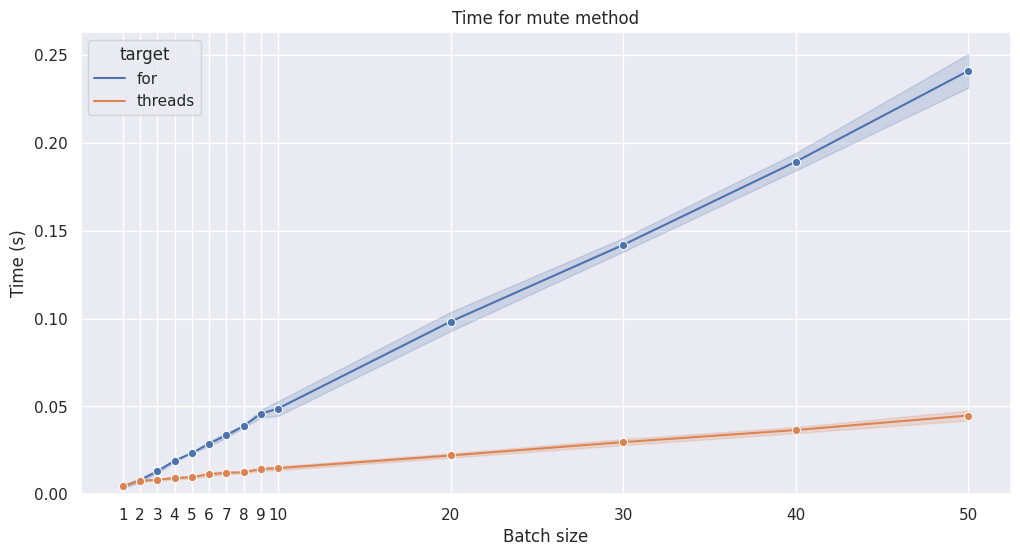

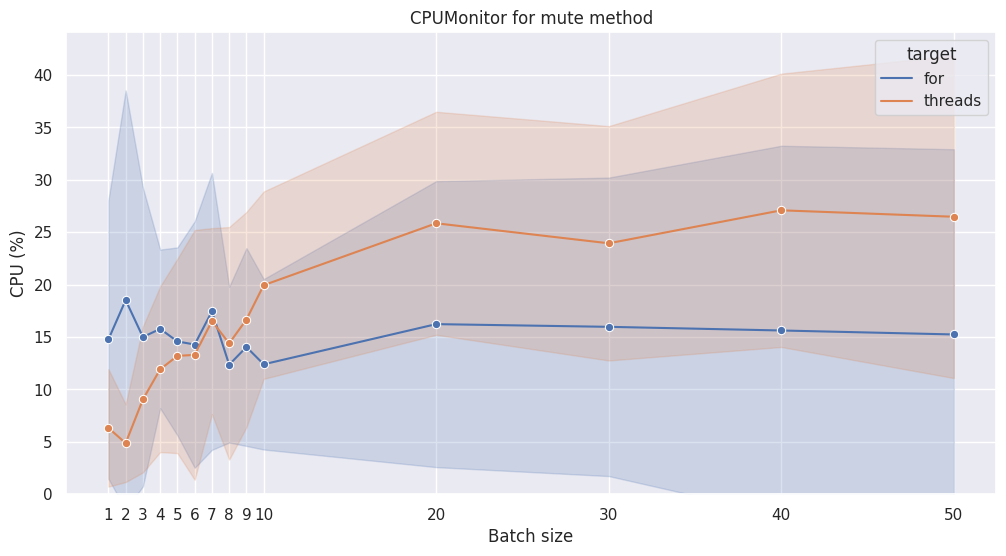

In [12]:
muter = Muter(offsets=[1000, 2000, 3000], times=[100, 300, 600])
mute_bm = Benchmark(method_name='mute', method_kwargs={'src': 'raw', 'muter': muter},
                    root_pipeline=load_pipeline, **default_kwargs)

mute_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_vertical_velocity_spectrum

100%|██████████| 22/22 [03:12<00:00,  8.73s/it]


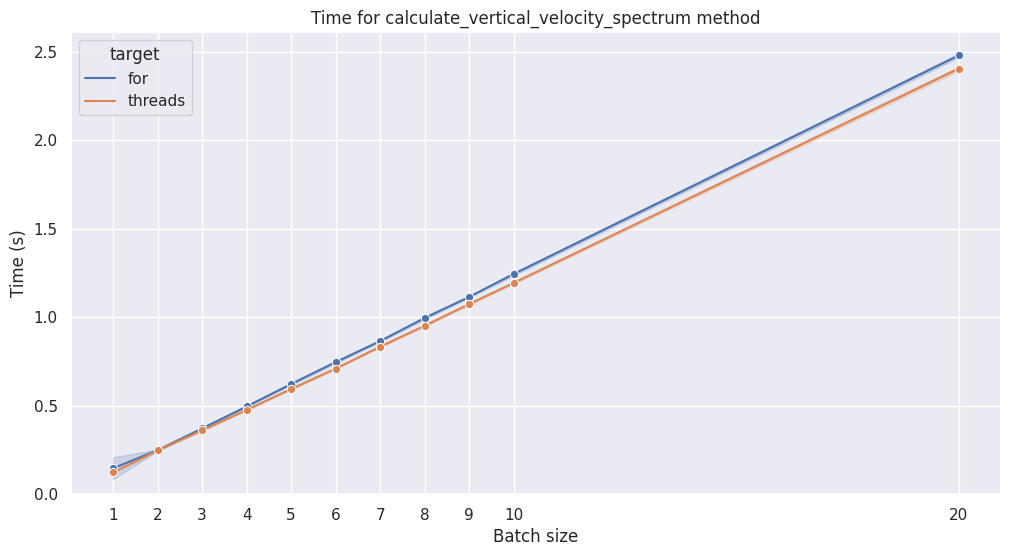

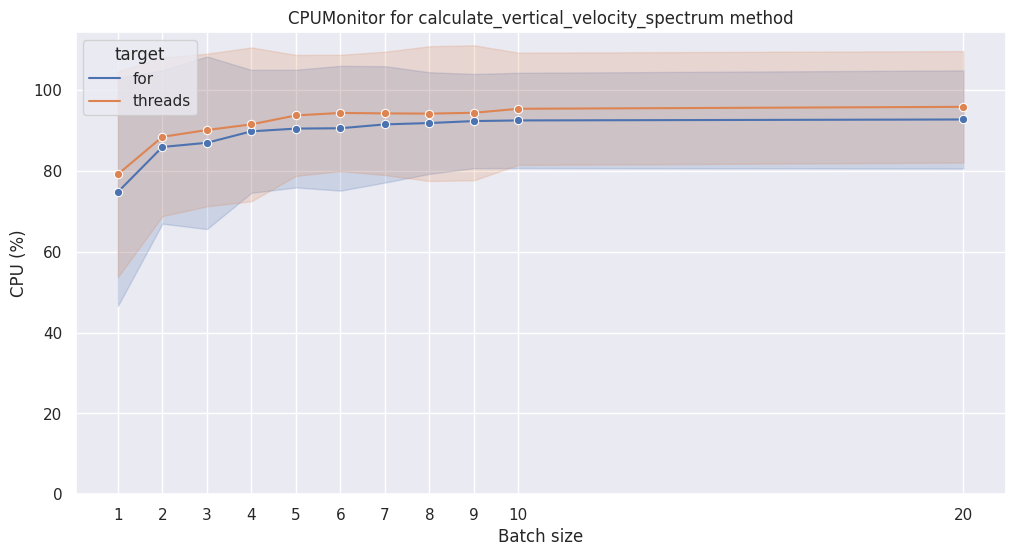

In [13]:
method_kwargs = {'src': 'raw'}
velocity_spectrum_bm = Benchmark(method_name='calculate_vertical_velocity_spectrum', method_kwargs=method_kwargs,
                         root_pipeline=sort_pipeline, **long_running_kwargs)

velocity_spectrum_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_residual_velocity_spectrum

100%|██████████| 22/22 [01:39<00:00,  4.53s/it]


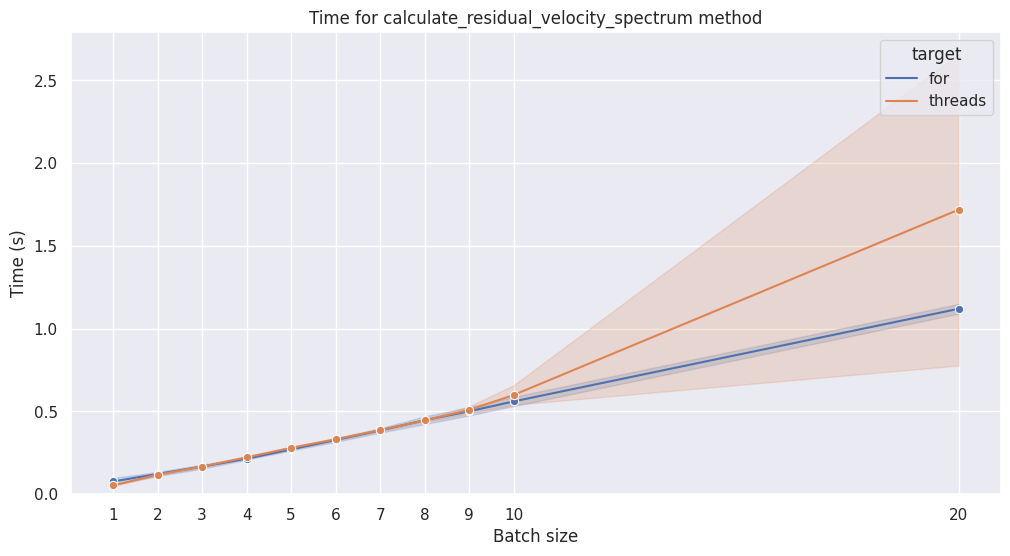

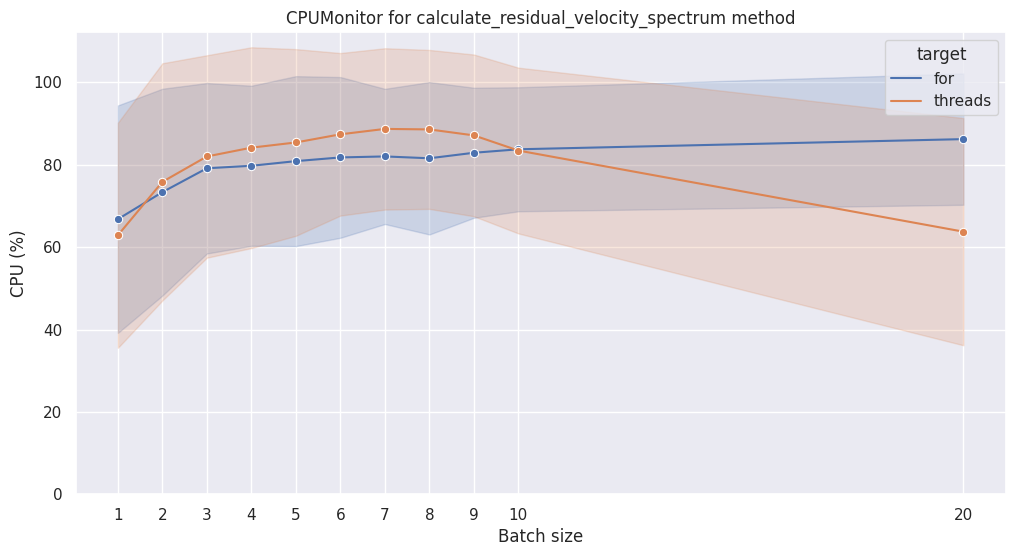

In [14]:
method_kwargs = {'src': 'raw',  'stacking_velocity': DEFAULT_STACKING_VELOCITY}
res_velocity_spectrum_bm = Benchmark(method_name='calculate_residual_velocity_spectrum', method_kwargs=method_kwargs,
                             root_pipeline=sort_pipeline, **long_running_kwargs)

res_velocity_spectrum_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### get_central_gather

100%|██████████| 28/28 [04:20<00:00,  9.30s/it]


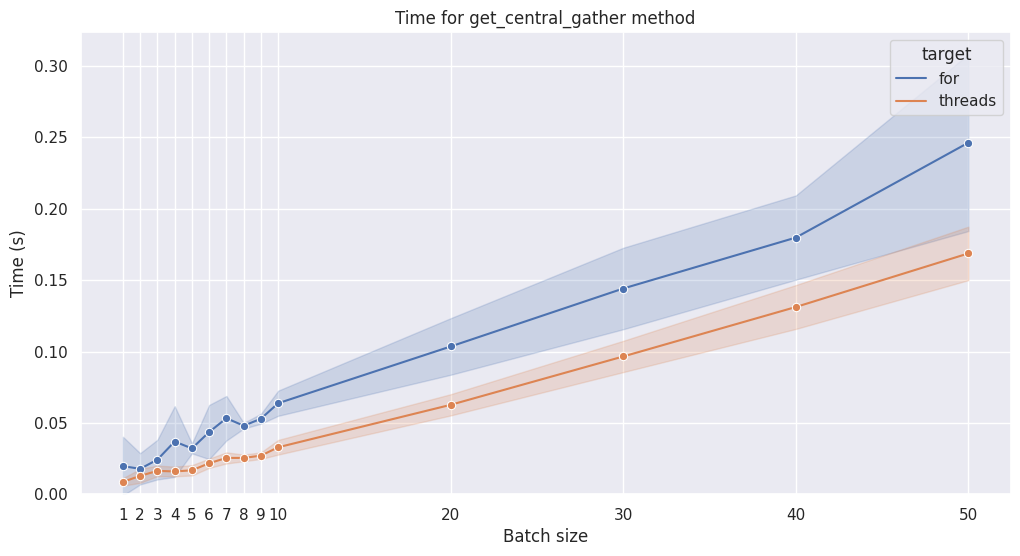

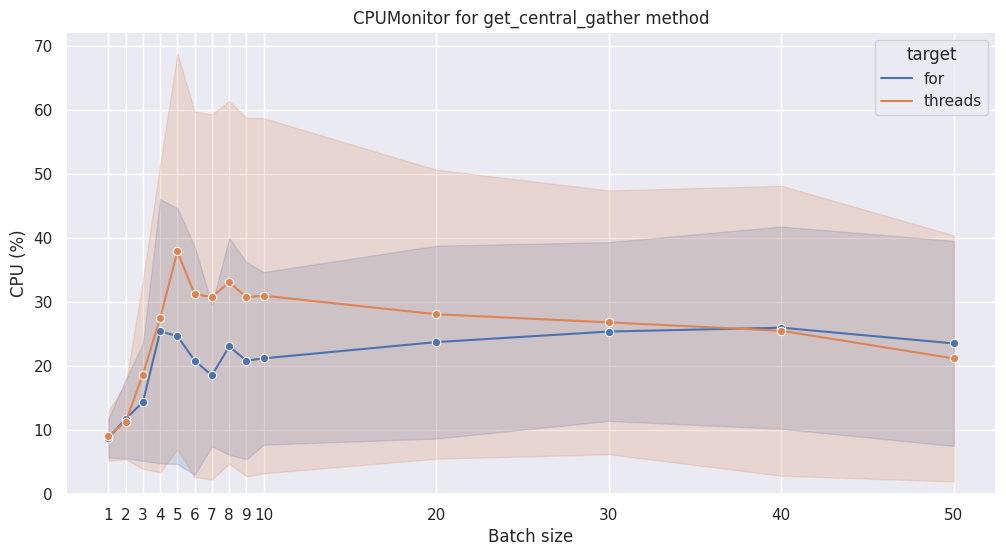

In [15]:
get_central_gather_bm = Benchmark(method_name='get_central_gather', method_kwargs={'src': 'raw'},
                                  root_pipeline=load_pipeline, **supergather_kwargs)

get_central_gather_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_nmo

100%|██████████| 28/28 [00:35<00:00,  1.25s/it]


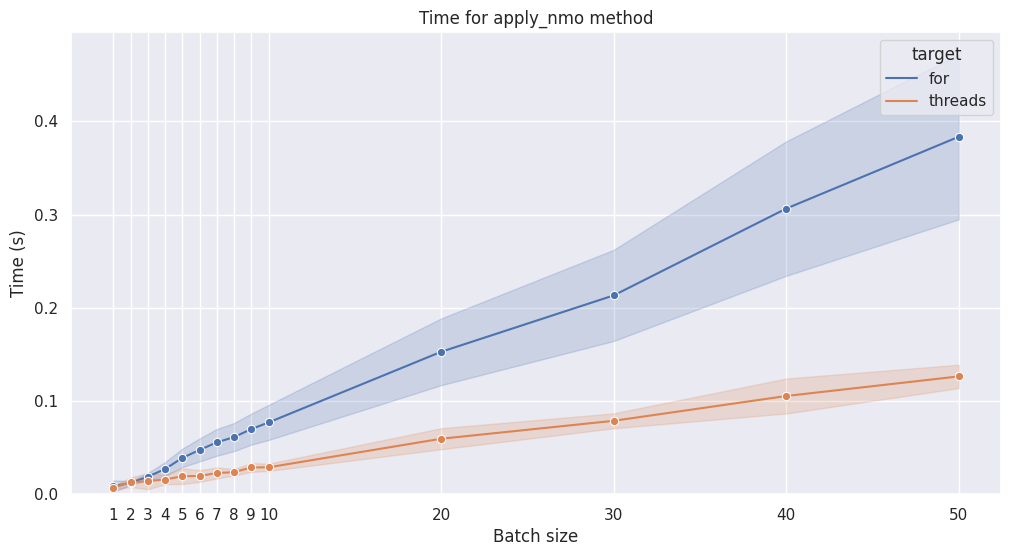

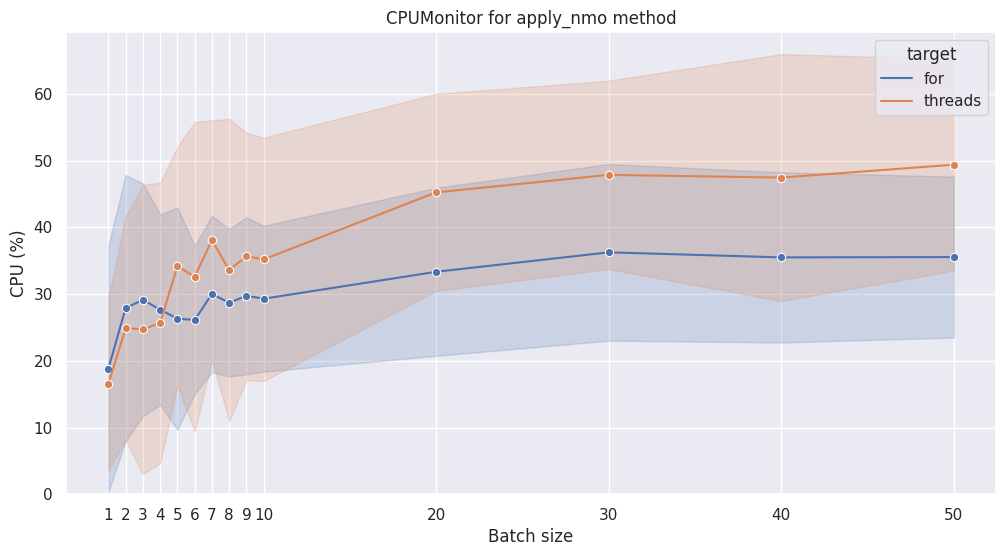

In [16]:
apply_nmo_bm = Benchmark(method_name='apply_nmo', method_kwargs={'src': 'raw', 'stacking_velocity': DEFAULT_STACKING_VELOCITY},
                         root_pipeline=load_pipeline, **default_kwargs)

apply_nmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### stack

100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


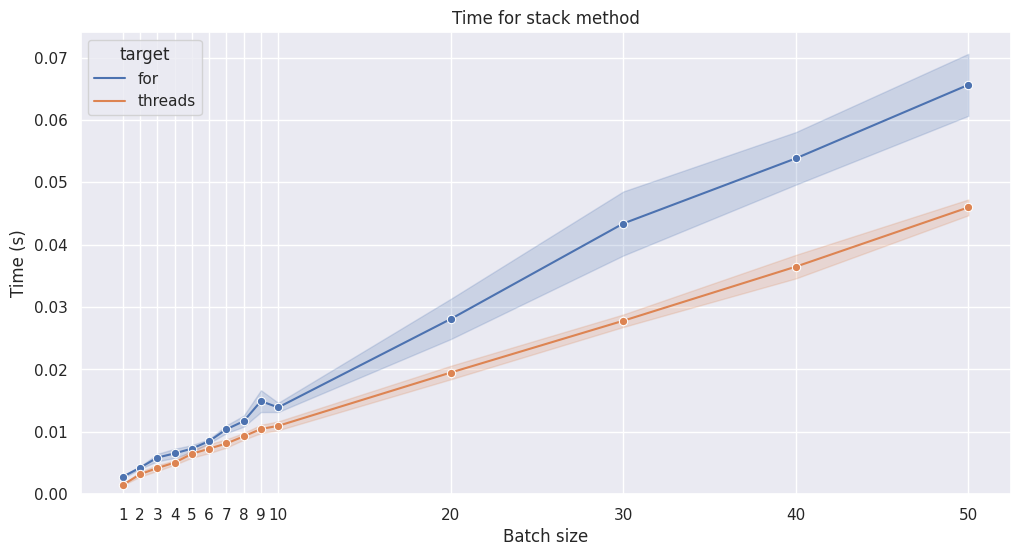

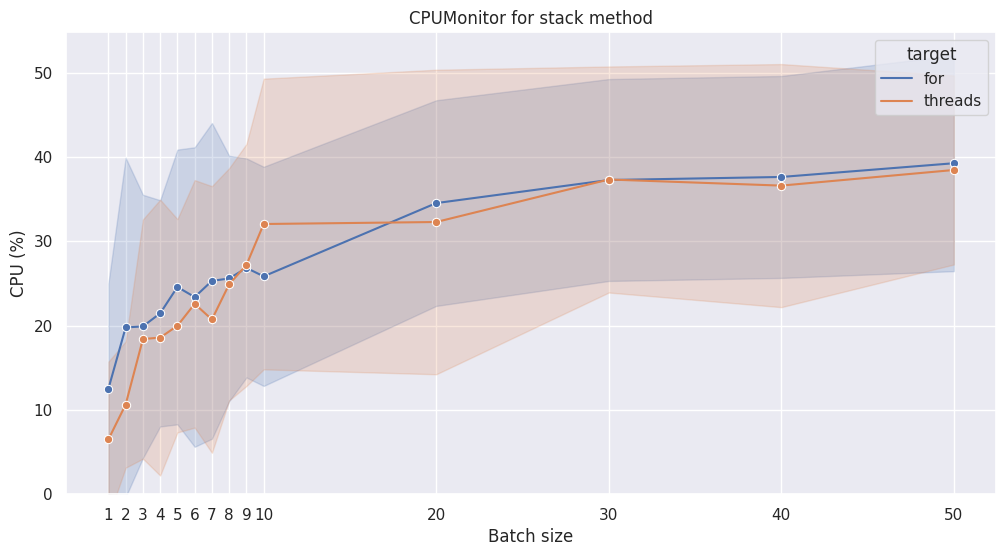

In [17]:
stack_bm = Benchmark(method_name='stack', method_kwargs={'src': 'raw'},
                     root_pipeline=load_pipeline, **default_kwargs)

stack_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_standard


100%|██████████| 28/28 [01:08<00:00,  2.44s/it]


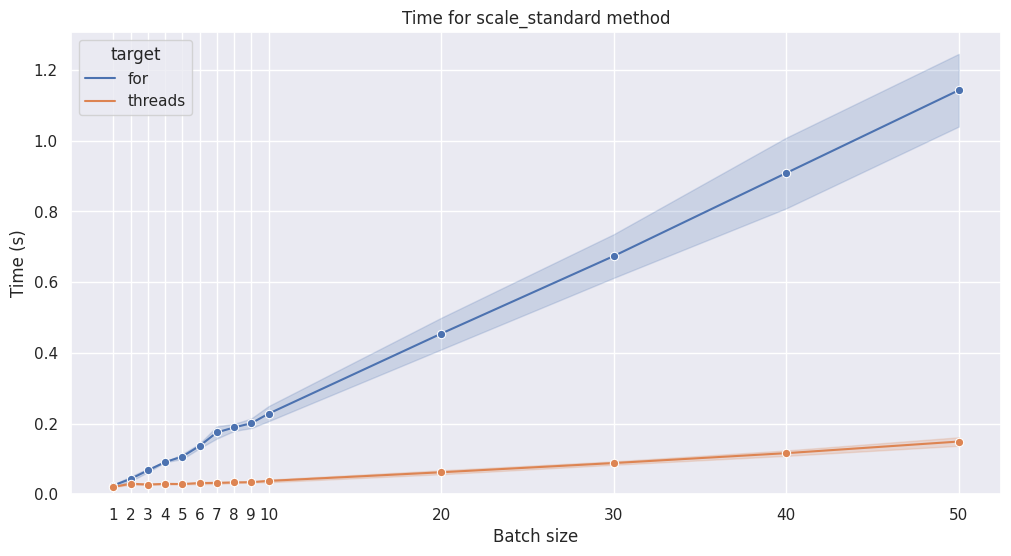

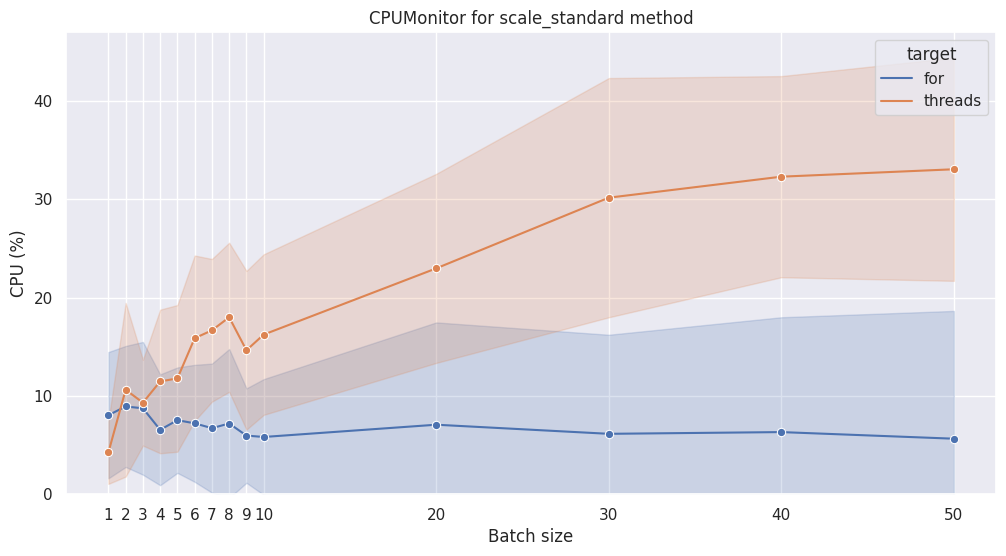

In [18]:
scale_std_bm = Benchmark(method_name='scale_standard', method_kwargs={'src': 'raw'},
                         root_pipeline=load_pipeline, **default_kwargs)

scale_std_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_maxabs

100%|██████████| 22/22 [03:53<00:00, 10.59s/it]


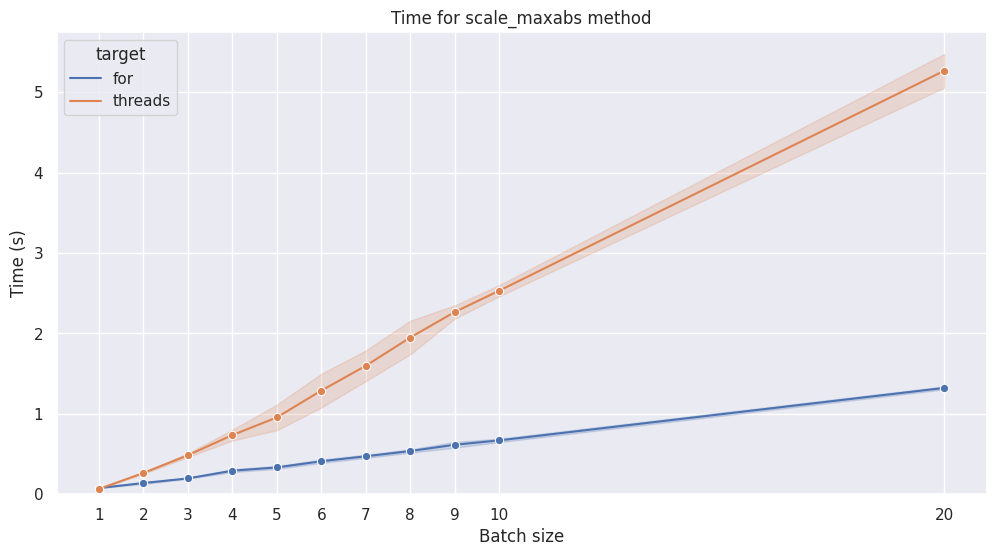

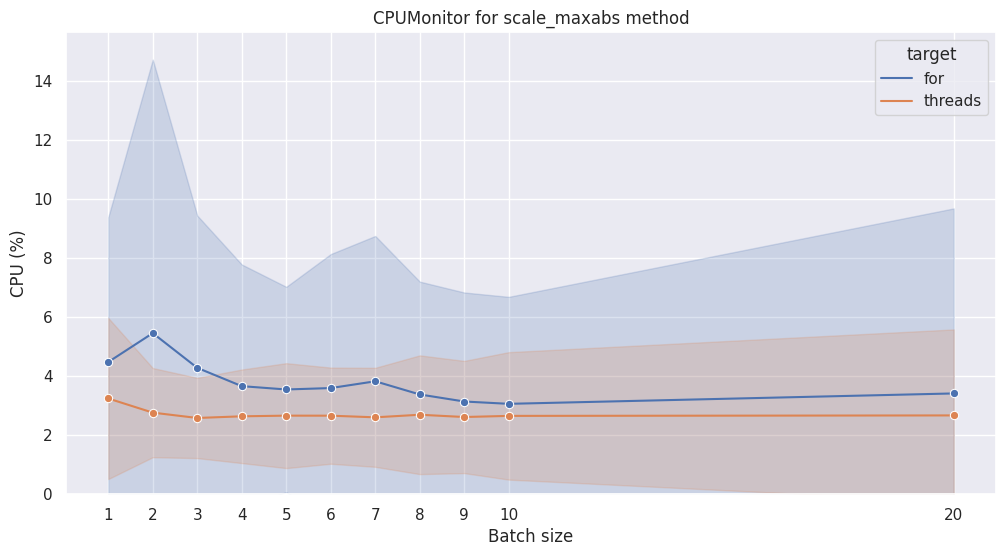

In [19]:
scale_maxabs_bm = Benchmark(method_name='scale_maxabs', method_kwargs={'src': 'raw'},
                            root_pipeline=load_pipeline, **long_running_kwargs)

scale_maxabs_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_minmax

100%|██████████| 22/22 [03:50<00:00, 10.50s/it]


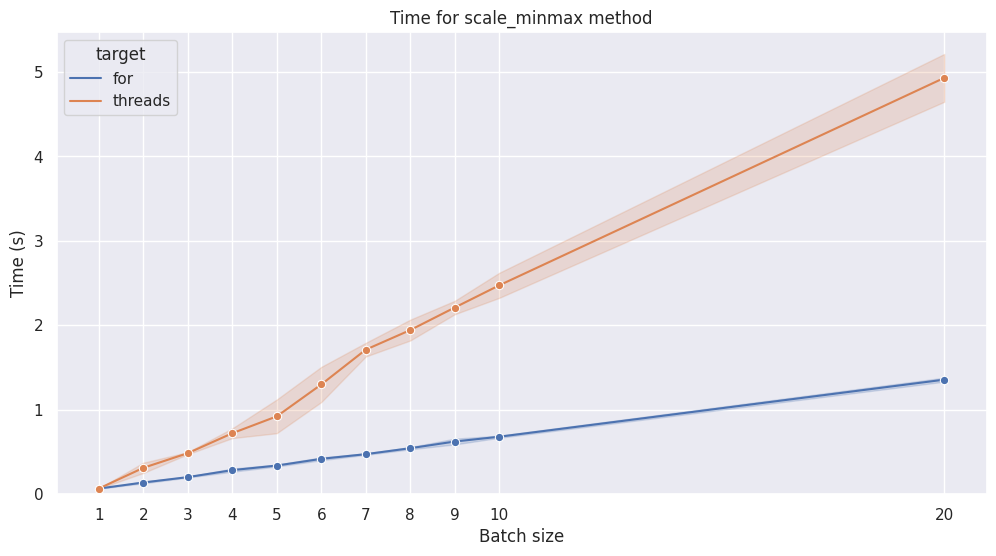

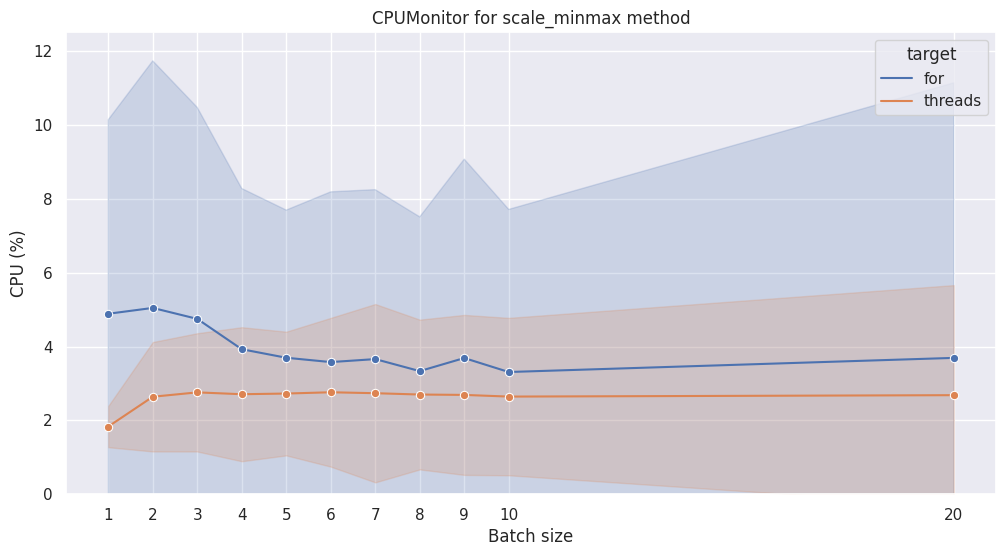

In [20]:
scale_minmax_bm = Benchmark(method_name='scale_minmax', method_kwargs={'src': 'raw'},
                            root_pipeline=load_pipeline, **long_running_kwargs)

scale_minmax_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### crop

100%|██████████| 28/28 [00:21<00:00,  1.29it/s]


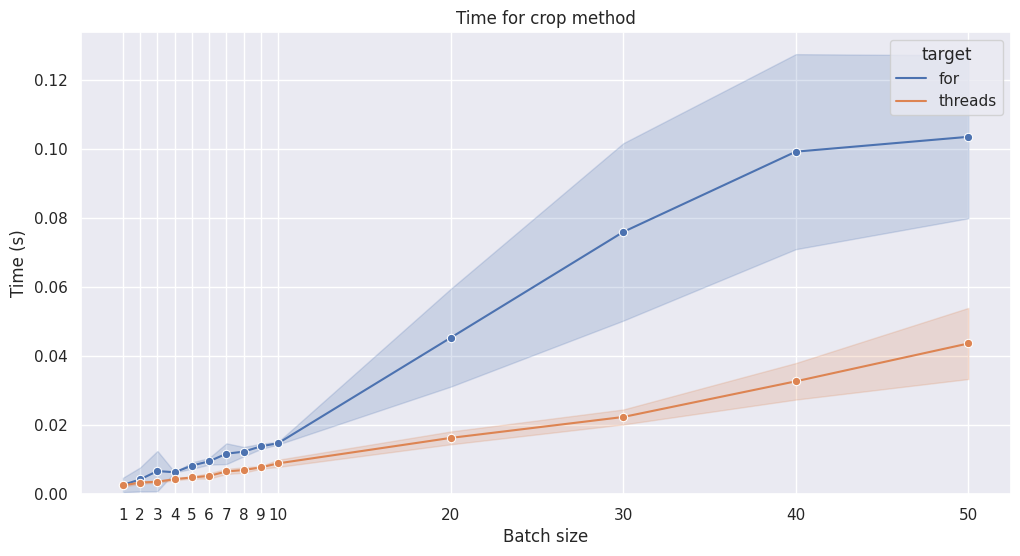

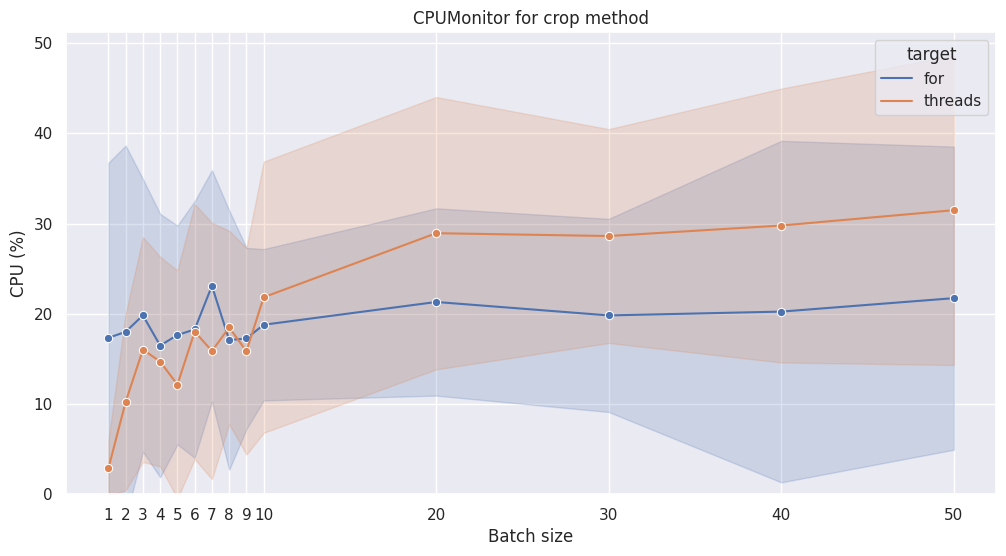

In [21]:
method_kwargs = {'src': 'raw', 'crop_shape': (200, 500), 'origins': 'random', 'n_crops': 16}
crop_bm = Benchmark(method_name='crop', method_kwargs=method_kwargs,
                    root_pipeline=load_pipeline, **default_kwargs)

crop_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### resample

100%|██████████| 28/28 [00:58<00:00,  2.10s/it]


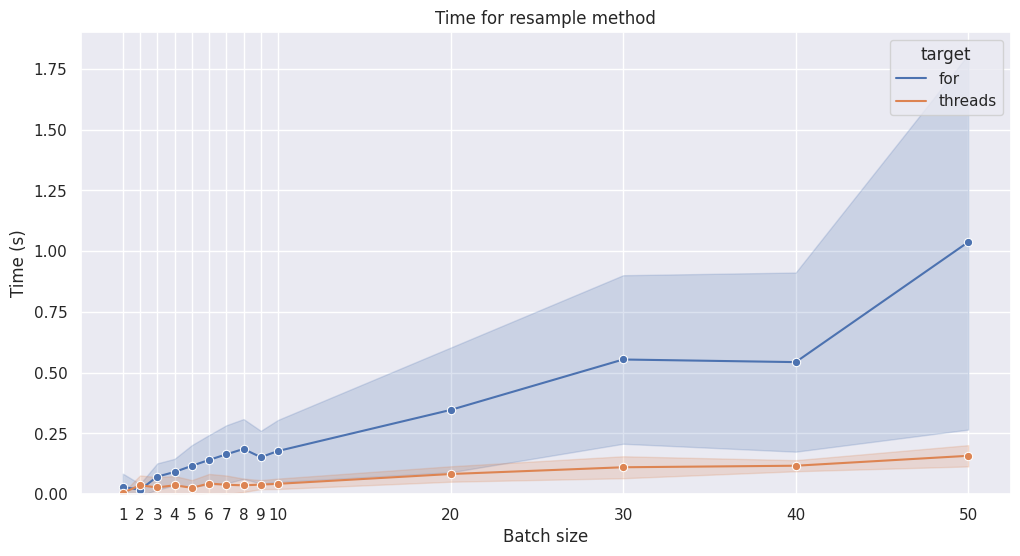

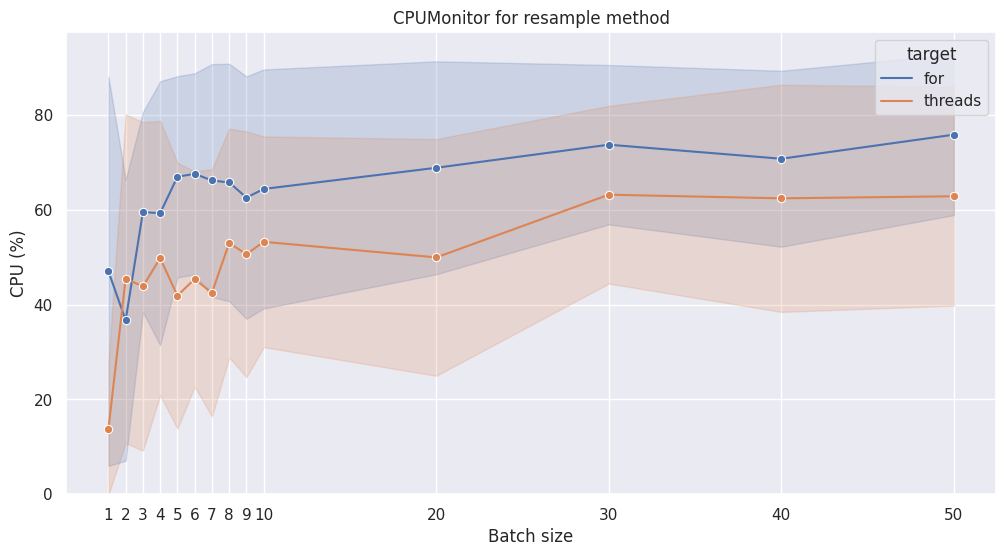

In [22]:
resample_bm = Benchmark(method_name='resample', method_kwargs={'src': 'raw', 'new_sample_interval': 1}, 
                        root_pipeline=load_pipeline, **default_kwargs)

resample_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### bandpass_filter

100%|██████████| 28/28 [00:48<00:00,  1.74s/it]


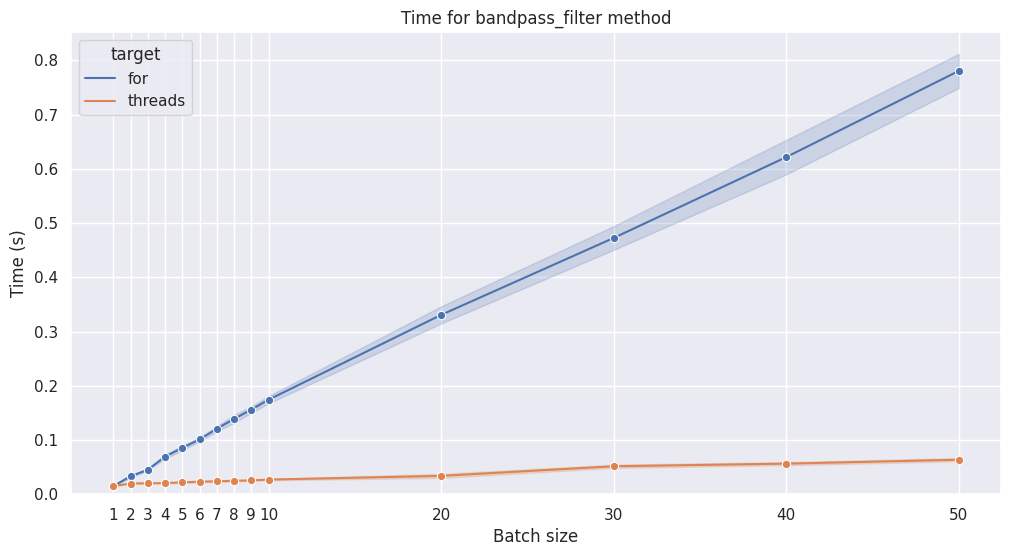

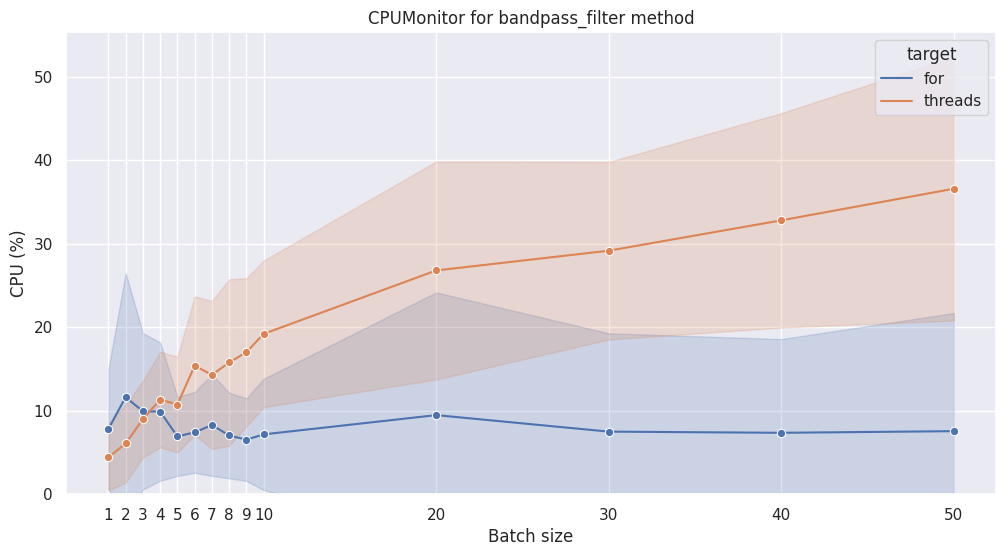

In [23]:
bandpass_bm = Benchmark(method_name='bandpass_filter', method_kwargs={'src': 'raw', 'low' : 10, 'high': 50}, 
                        root_pipeline=load_pipeline, **default_kwargs)

bandpass_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_agc

In [24]:
apply_agc_bm = Benchmark(method_name='apply_agc', method_kwargs={'src': 'raw', 'mode': 'rms'}, 
                         root_pipeline=load_pipeline, **default_kwargs)

apply_agc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


#### undo_agc

100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


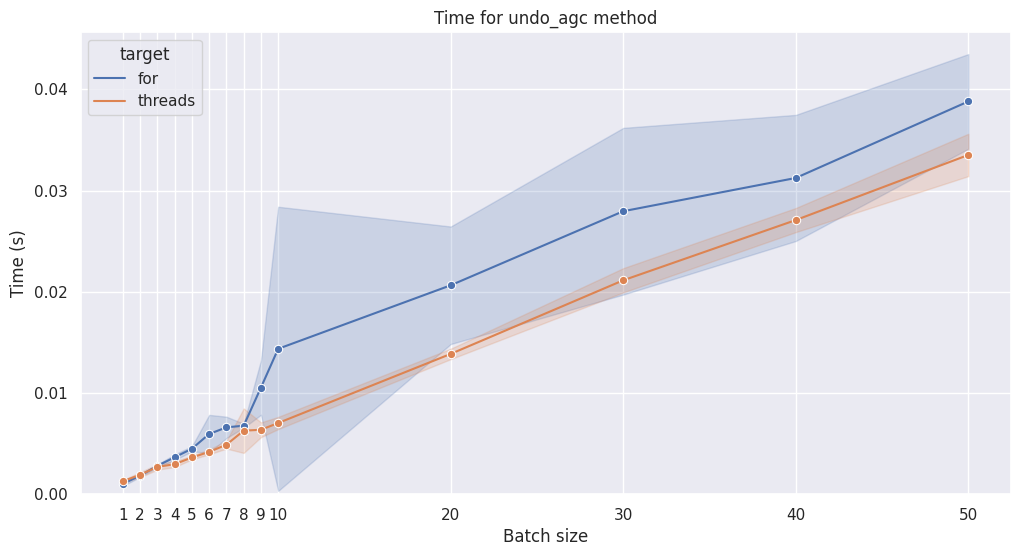

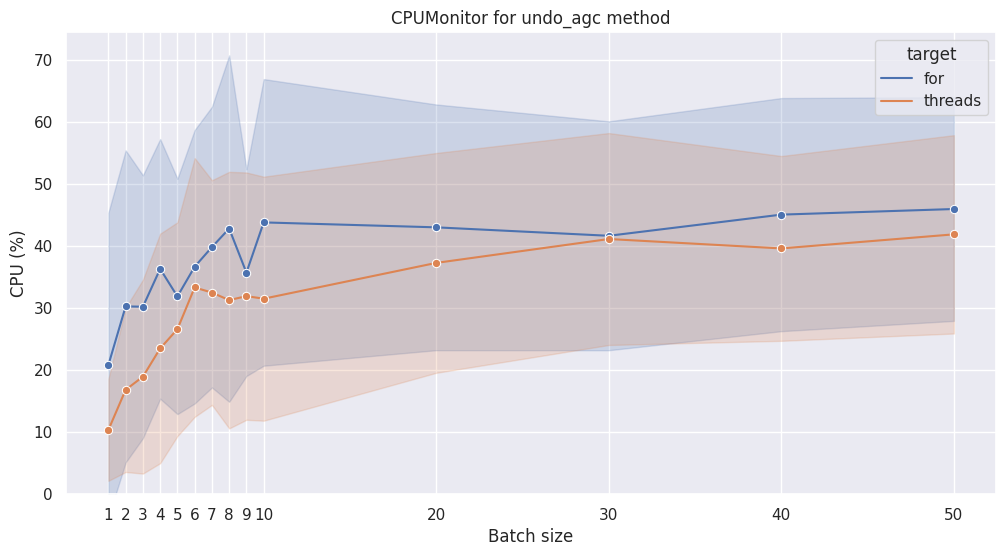

In [25]:
agc_pipeline = load_pipeline + Pipeline().apply_agc(src='raw', mode='rms', dst_coefs='coefs_gather')

undo_agc_bm = Benchmark(method_name='undo_agc', method_kwargs={'src': 'raw', 'src_coefs': 'coefs_gather'}, 
                         root_pipeline=agc_pipeline, **default_kwargs)

undo_agc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

#### apply_sdc

100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


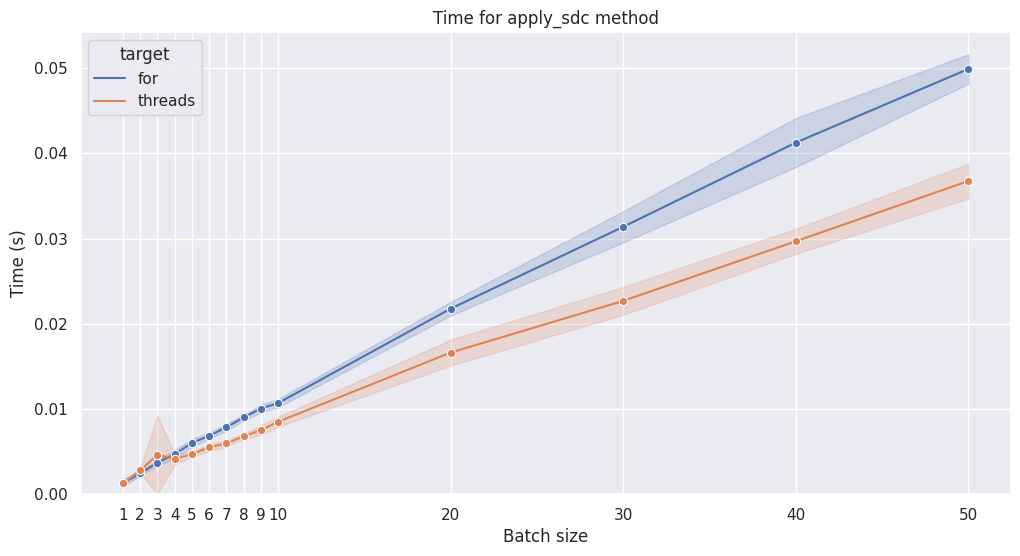

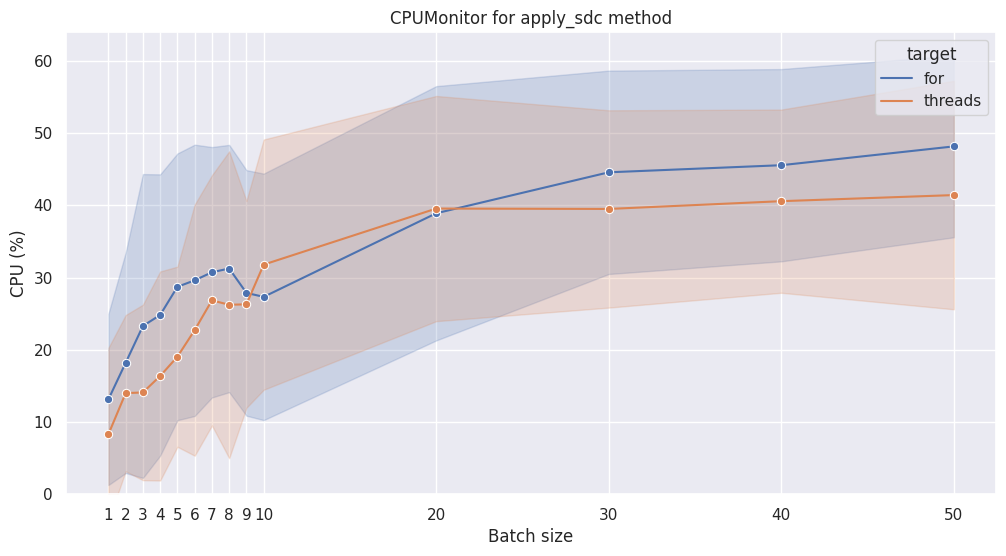

In [26]:
apply_sdc_bm = Benchmark(method_name='apply_sdc', method_kwargs={'src': 'raw'}, 
                         root_pipeline=load_pipeline, **default_kwargs)

apply_sdc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### undo_sdc

100%|██████████| 28/28 [00:21<00:00,  1.31it/s]


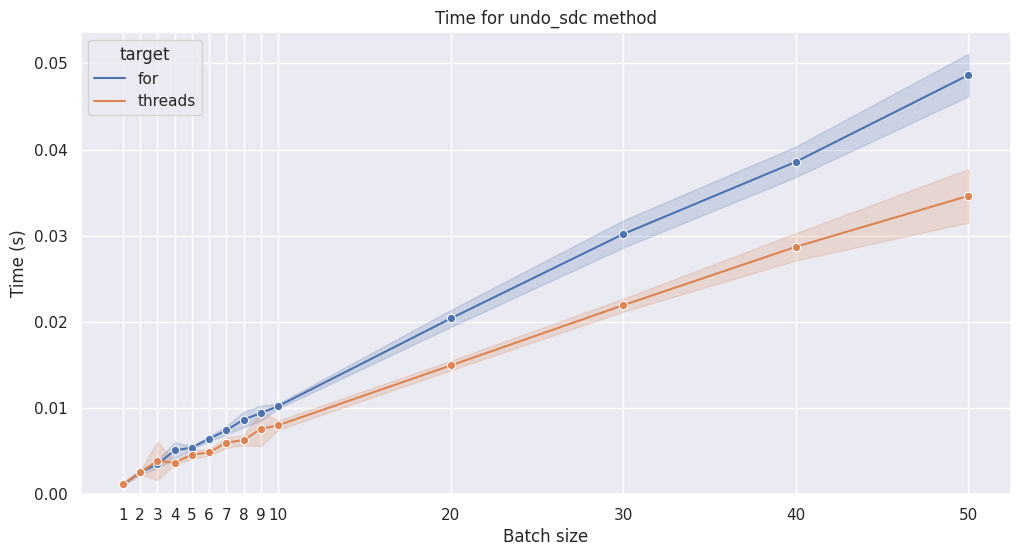

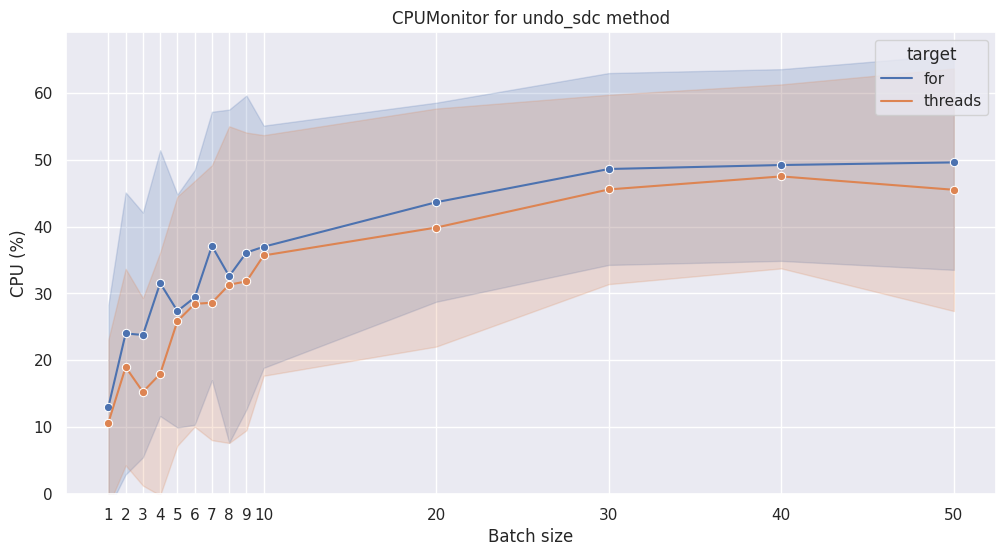

In [27]:
sdc_pipeline = load_pipeline + Pipeline().apply_sdc(src='raw')
undo_sdc_bm = Benchmark(method_name='undo_sdc', method_kwargs={'src': 'raw'}, 
                        root_pipeline=sdc_pipeline, **default_kwargs)

undo_sdc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_refractor_velocity

100%|██████████| 28/28 [01:42<00:00,  3.64s/it]


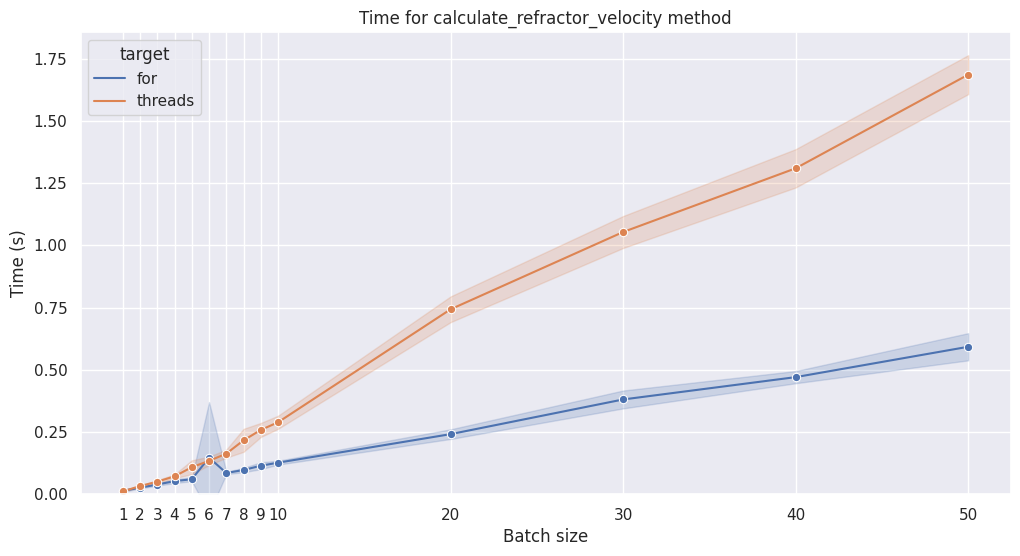

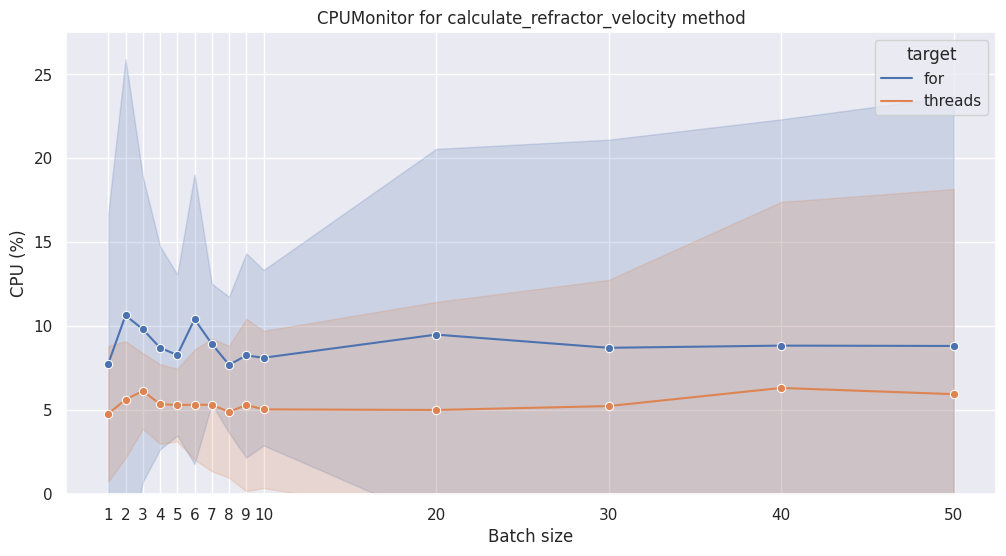

In [28]:
refractor_velocity_bm = Benchmark(method_name='calculate_refractor_velocity', method_kwargs={'src': 'raw', 'n_refractors': 2},
                                  root_pipeline=load_pipeline, **default_kwargs)

refractor_velocity_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_lmo

100%|██████████| 28/28 [00:29<00:00,  1.04s/it]


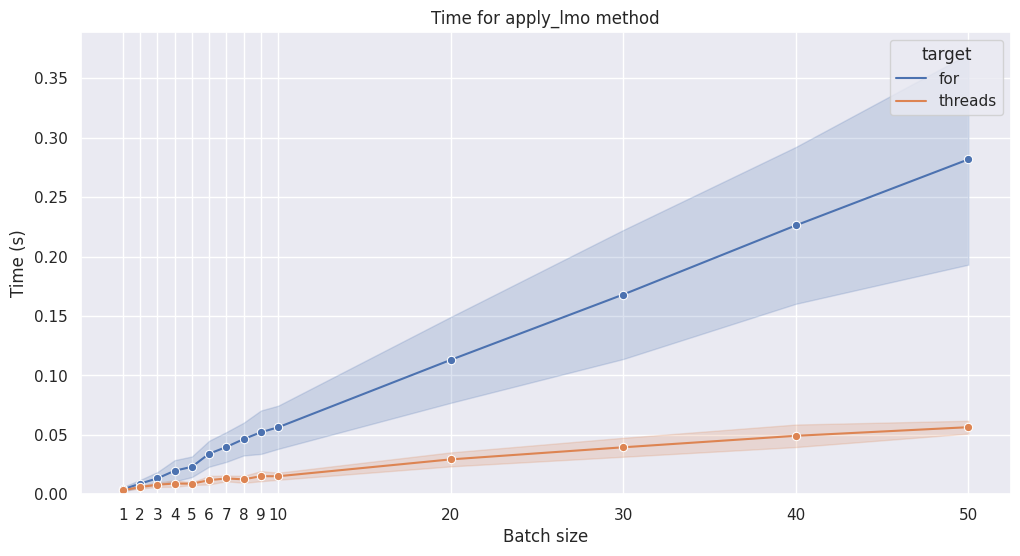

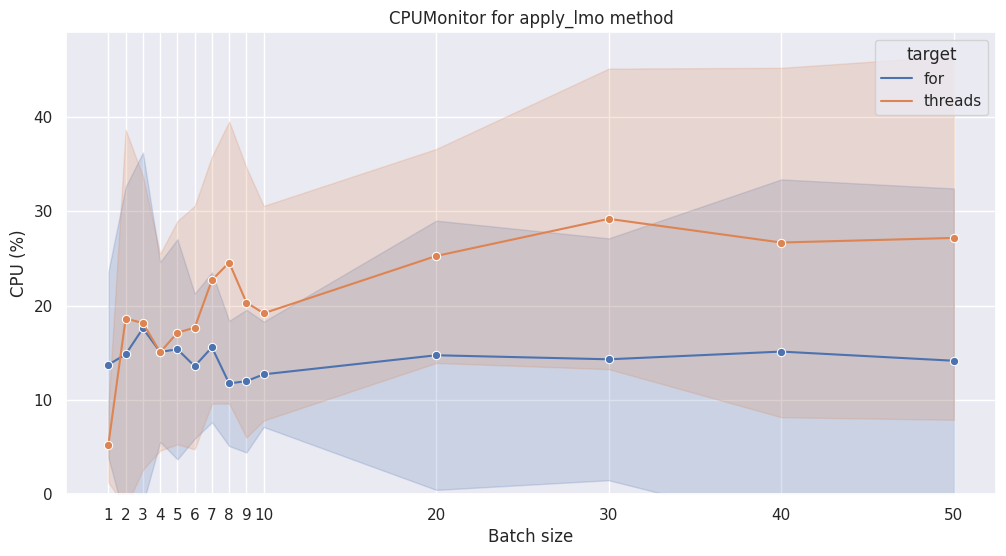

In [29]:
refractor_velocity = RefractorVelocity(t0=10, v1=1500)
apply_lmo_bm = Benchmark(method_name='apply_lmo', method_kwargs={'src': 'raw', 'refractor_velocity': refractor_velocity},
                         root_pipeline=load_pipeline, **default_kwargs)

apply_lmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_stacking_velocity

100%|██████████| 22/22 [03:45<00:00, 10.27s/it]


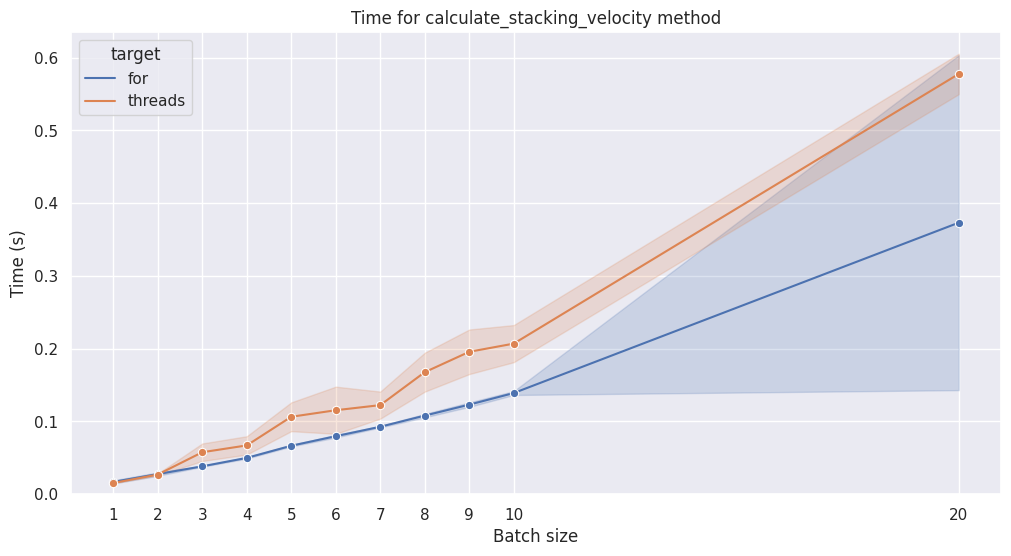

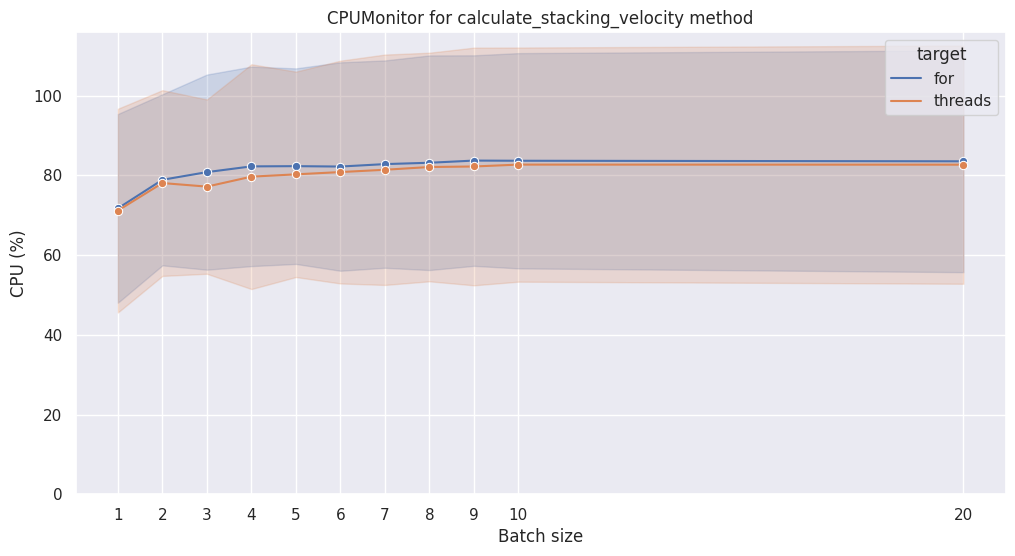

In [30]:
stacking_velocity_pipeline = sort_pipeline + Pipeline().calculate_vertical_velocity_spectrum(src="raw", dst="spectrum")
method_kwargs = {'src': 'spectrum'}
stacking_velocity_bm = Benchmark(method_name='calculate_stacking_velocity', method_kwargs=method_kwargs,
                                 root_pipeline=stacking_velocity_pipeline, **long_running_kwargs)

stacking_velocity_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### assemble_gather

100%|██████████| 28/28 [00:50<00:00,  1.82s/it]


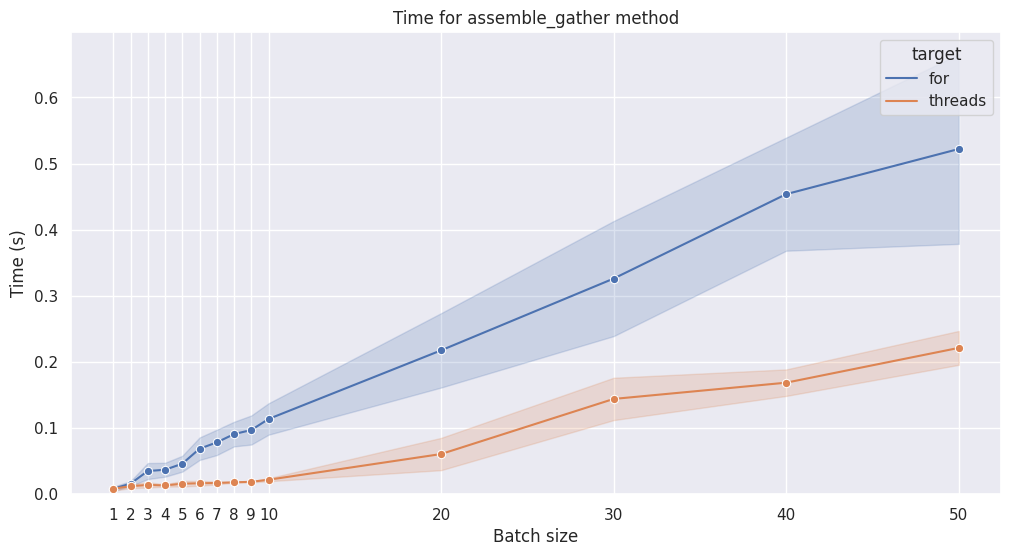

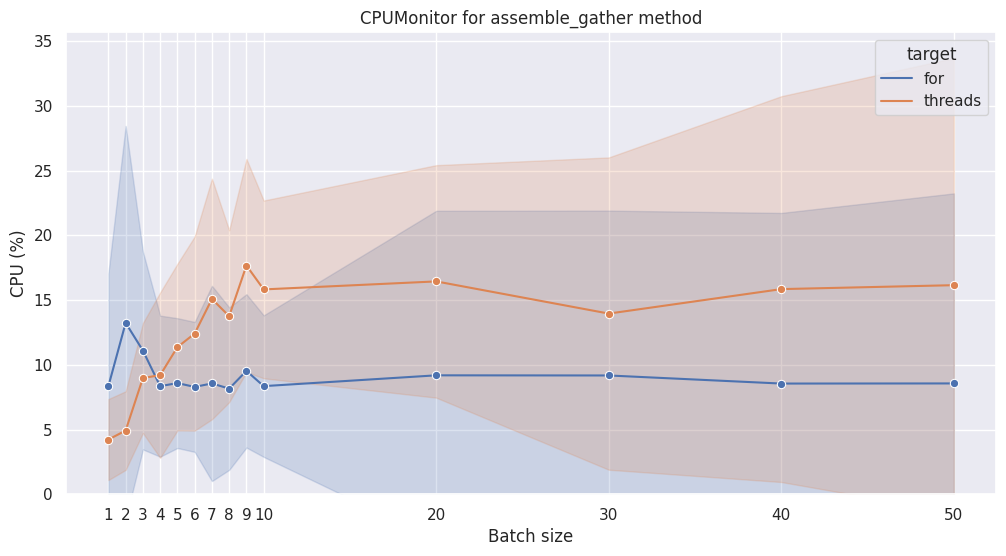

In [31]:
crop_pipeline = load_pipeline + Pipeline().crop(src='raw', dst='cropped', origins='grid', crop_shape=(200, 500))
assemble_bm = Benchmark(method_name='assemble_gather', method_kwargs={'src': 'cropped'}, 
                        root_pipeline=crop_pipeline, **default_kwargs)

assemble_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

Destroy temporary folder

In [32]:
tmp_dir.cleanup()